In [2]:
from os.path import join,exists,realpath,dirname,basename
from os import makedirs,listdir
import numpy as np, cPickle, editdistance, seaborn as sns
import matplotlib.pyplot as plt, pandas as pd, itertools, glob
from scipy.stats import entropy
from matplotlib.font_manager import FontProperties
from IPython.display import display
from collections import defaultdict
from IPython.display import display
%matplotlib inline

In [3]:
rundir = '/cluster/zeng/code/research/OFTL-GAN/runs'

In [4]:
mapper = ['A','C','G','T']
re_mapper = {'A':0,'C':1,'G':2,'T':3}

In [5]:
def decode(data):
    mydict = ['A', 'C', 'G', 'T']
    out = []
    for x in data:
        out.append(''.join([mydict[np.argmax(y)] for y in x.squeeze().transpose()])) 
    return np.asarray(out)

def retrieve_bestrun_samples(pattern, use_abs=False):
    runs = glob.glob(pattern)
    bestloss = None
    bestrun = ''
    for run in runs:
        with open(join(run, 'history.pkl')) as f:
            history = cPickle.load(f)
        
        test_disc_loss = history['test']['discriminator']
        if type(test_disc_loss[0]) is not float and type(test_disc_loss[0]) is not np.float64:
            test_disc_loss = [x[0] for x in test_disc_loss]
        if use_abs:
            test_disc_loss = np.abs(test_disc_loss)
        t_argbest = np.argmin(test_disc_loss) 
        if bestloss is None or test_disc_loss[t_argbest] < bestloss:
            bestloss = test_disc_loss[t_argbest]
            bestrun = join(run, 'samples_epoch_{0:03d}_generated.pkl'.format(t_argbest))
    
    with open(bestrun) as f:
        best_sample = cPickle.load(f)
    return best_sample, bestrun, bestloss

def plot_acgt_distr(rundir, epoch_num, seqlen):
    
    all_distr = {'A':[], 'C':[], 'G':[], 'T':[]}
    for epoch in range(epoch_num):
        with open(join(rundir, 'samples_epoch_{0:03d}_generated.pkl'.format(epoch))) as f:
            sample = cPickle.load(f).squeeze().swapaxes(1,2)
        distr = defaultdict(int)
        for x in sample:
            for y in x:
                distr[mapper[y.argmax()]]+=1
        for x in ['A', 'C', 'G', 'T']:
            all_distr[x].append(distr[x]/float(len(sample)))
    for x in ['A', 'C', 'G', 'T']:
        plt.plot(range(epoch_num), all_distr[x], label=x)
    plt.legend()
        
def data2prob(data_ori,idx_mapper):
    # Calcualte the emperical kmer distribution from a generated dataset
    out = np.zeros(len(idx_mapper.keys()))
    data = data_ori.squeeze().swapaxes(1,2)
    for x in data:
        t_data = [ mapper[y.argmax()]   for y in x]
        out[idx_mapper[''.join(t_data)]] += 1
    return out/sum(out)

def kl_compare(samples, motif_file, seqlen):
    # All posible kmers
    candidate = [''.join(p) for p in itertools.product(mapper, repeat=seqlen)]

    # Map each kmer to its index in the list
    idx_mapper = dict()
    for idx,x in enumerate(candidate):
        idx_mapper[x] = idx

    # Read the motif
    with open(motif_file) as f:
        f.readline()
        motif_mat = [map(float,x.split()) for x in f]

    # Calculate the expected probability of each kmer
    design_p = np.zeros(len(candidate))
    for idx,x in enumerate(candidate):
        t_p = 1.0
        for cidx, c in enumerate(list(x)):
            t_p *= motif_mat[cidx][re_mapper[c]]
        design_p[idx] = t_p

    pred_p = data2prob(samples, idx_mapper)
    return entropy(pred_p, design_p) - entropy(pred_p, pred_p) 

In [6]:
def analysis(pattern):
    best_perform = []
    last_perform = []
    for optimizer in optimizers:
        versions2use = versions if optimizer !='SGD' else ['0']
        for version in versions2use:
            for schedule in schedules:              
                t_pattern = pattern.replace('OPTIMIZER', optimizer)
                t_pattern = t_pattern.replace('SCHEDULE', schedule)
                t_pattern = t_pattern.replace('VERSION', version)
                t_pattern = t_pattern.replace('NETWORK', network)
                t_pattern = t_pattern.replace('GINTER', str(ginter))
                
                best_pattern = t_pattern.replace('LR', '*')
                best_sample, bestrun, bestloss = retrieve_bestrun_samples(best_pattern)
                best_perform.append([optimizer, version, schedule, \
                                     kl_compare(best_sample, motif_file, motif_len)])               
                for lr in lrs:
                    last_pattern = t_pattern.replace('LR', lr)
                    lastrun = join(last_pattern, 'samples_epoch_{0:03d}_generated.pkl'.format(n_epoch))
                    with open(lastrun) as f:
                        last_sample = cPickle.load(f)
                    last_perform.append([optimizer, version, schedule, lr, \
                                         kl_compare(last_sample, motif_file, motif_len)])
    display(pd.DataFrame(best_perform,\
                         columns=['optimizer', 'version', 'schedule', 'KL']).pivot_table(values='KL', \
            index=['optimizer','version'], columns=['schedule']))
    display(pd.DataFrame(last_perform,\
                         columns=['optimizer', 'version', 'schedule', 'lr', 'KL']).pivot_table(values='KL', \
        index=['optimizer','version'], columns=['lr', 'schedule']))

## ATAGGC

In [23]:
dataset = 'motif_spikein_ATAGGC'
motif_file = join(rundir, '../data/motifs/ATAGGC.pwm')
motif_len = 6

### WGAN-GP

In [105]:
versions = ['1', '2', '3']
schedules = ['None', 'adagrad']
optimizers = ['OMDA', 'SGD']
network = 'wgan'
ginter = 5

In [176]:
# gp=1e-2
pattern = join(rundir, dataset, 'OPTIMIZER_SCHEDULE_vVERSION_lrLR_NETWORK_ginterGINTER')
analysis(pattern)

schedule               None   adagrad
optimizer version                    
OMDA      1        3.468182  2.765943
          2        3.338585  3.861532
          3        3.378136  3.668743
SGD       0        3.351842  3.951856

lr                    5e-03               5e-04               5e-05          
schedule               None   adagrad      None   adagrad      None   adagrad
optimizer version                                                            
OMDA      1        2.076862  2.109780  1.981408  2.286600  2.328895  1.957158
          2        2.185754  2.317016  1.841750  1.935154  2.262838  2.082213
          3        1.787751  2.024443  1.962307  2.154582  1.853142  2.097235
SGD       0        2.695434  0.732869  3.519873  4.041645  4.234674  3.908184

In [178]:
# gp=1e-3
pattern = join(rundir, dataset, 'OPTIMIZER_SCHEDULE_vVERSION_lrLR_NETWORK_ginterGINTER_gp0.001')
analysis(pattern)

schedule               None   adagrad
optimizer version                    
OMDA      1        2.593195  1.927118
          2        2.250306  1.467891
          3        2.645655  1.407436
SGD       0        2.655927  3.381089

lr                    5e-03               5e-04               5e-05          
schedule               None   adagrad      None   adagrad      None   adagrad
optimizer version                                                            
OMDA      1        0.614520  0.802271  0.429005  0.569156  0.547112  0.436061
          2        0.599519  0.616537  0.727567  0.610550  0.570501  0.734785
          3        0.580727  0.615565  0.468084  0.564896  0.606411  0.500082
SGD       0        1.064896  1.081824  3.064354  3.659802  3.871923  4.089729

In [179]:
# gp=1e-4
pattern = join(rundir, dataset, 'OPTIMIZER_SCHEDULE_vVERSION_lrLR_NETWORK_ginterGINTER_gp1e-4')
analysis(pattern)

schedule               None   adagrad
optimizer version                    
OMDA      1        1.017193  0.932053
          2        1.041961  1.750936
          3        0.939629  1.169091
SGD       0        2.061151  1.779396

lr                    5e-03               5e-04               5e-05          
schedule               None   adagrad      None   adagrad      None   adagrad
optimizer version                                                            
OMDA      1        0.501716  0.468053  0.429510  0.439227  0.384879  0.371827
          2        0.390569  0.438538  0.420772  0.394917  0.414981  0.473216
          3        0.372236  0.434589  0.359716  0.372137  0.395333  0.403537
SGD       0        0.510509  2.501375  2.840438  3.140058  4.135054  3.883466

In [180]:
# gp=1e-1
pattern = join(rundir, dataset, 'OPTIMIZER_SCHEDULE_vVERSION_lrLR_NETWORK_ginterGINTER_gp0.1')
analysis(pattern)

schedule               None   adagrad
optimizer version                    
OMDA      1        7.863003  7.863003
          2        3.683489  7.863003
          3        7.863003  3.365284
SGD       0        3.709136  4.401447

lr                    5e-03               5e-04               5e-05          
schedule               None   adagrad      None   adagrad      None   adagrad
optimizer version                                                            
OMDA      1        7.863003  7.863003  7.863003  3.766079  4.501097  2.934882
          2        7.863003  7.863003  3.474613  7.863003  7.863003  3.323956
          3        7.863003  3.207873  7.863003  7.863003  7.863003  7.863003
SGD       0        3.683986  1.449289  3.854923  3.955005  3.783505  4.395236

#### gp=1e-4 50 run analysis

In [153]:
# Compare the KL divergence of the checkpoint with the lowest loss
pattern = join(rundir, dataset+'_50runs', 'runRUN', 'OPTIMIZER_SCHEDULE_vVERSION_lr*_NETWORK_ginterGINTER_gp1e-4')
perform = []
for run in range(50):
    for optimizer in optimizers:
        versions2use = versions if optimizer !='SGD' else ['0']
        for version in versions2use:
            for schedule in schedules:
                t_pattern = pattern.replace('OPTIMIZER', optimizer)
                t_pattern = t_pattern.replace('SCHEDULE', schedule)
                t_pattern = t_pattern.replace('VERSION', version)
                t_pattern = t_pattern.replace('NETWORK', network)
                t_pattern = t_pattern.replace('GINTER', str(ginter))
                t_pattern = t_pattern.replace('RUN', str(run))
                best_sample, bestrun, bestloss = retrieve_bestrun_samples(t_pattern)
                barcode = '_'.join([optimizer, version, schedule])
                perform.append([optimizer, version, schedule, run, kl_compare(best_sample, motif_file, motif_len), barcode])

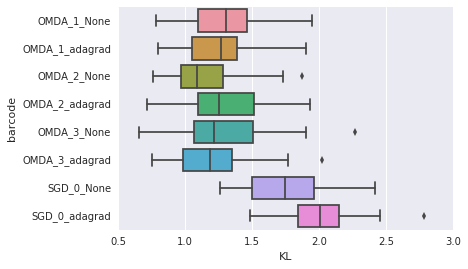

In [154]:
sns.boxplot(x='KL', y='barcode', \
            data=pd.DataFrame(perform, columns=['optimizer', 'version', 'schedule', 'run', 'KL', 'barcode']))

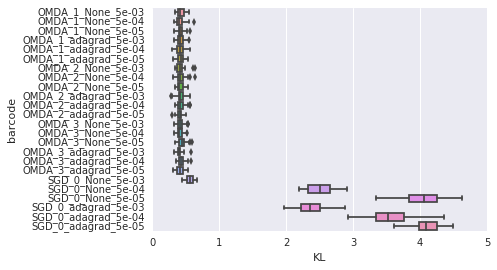

In [155]:
# Compare the KL divergence of the last checkpoint
pattern = join(rundir, dataset+'_50runs', 'runRUN', 'OPTIMIZER_SCHEDULE_vVERSION_lrLR_NETWORK_ginterGINTER_gp1e-4')
perform = []
for run in range(50):
    for optimizer in optimizers:
        versions2use = versions if optimizer !='SGD' else ['0']
        for version in versions2use:
            for schedule in schedules:
                for lr in lrs:
                    t_pattern = pattern.replace('OPTIMIZER', optimizer)
                    t_pattern = t_pattern.replace('SCHEDULE', schedule)
                    t_pattern = t_pattern.replace('VERSION', version)
                    t_pattern = t_pattern.replace('NETWORK', network)
                    t_pattern = t_pattern.replace('GINTER', str(ginter))
                    t_pattern = t_pattern.replace('LR', lr)
                    t_pattern = t_pattern.replace('RUN', str(run))
                    lastrun = join(t_pattern, 'samples_epoch_{0:03d}_generated.pkl'.format(n_epoch))
                    with open(lastrun) as f:
                        last_sample = cPickle.load(f)
                    barcode = '_'.join([optimizer, version, schedule, lr])
                    perform.append([optimizer, version, schedule, run, lr, kl_compare(last_sample, motif_file, motif_len), barcode])
sns.boxplot(x='KL', y='barcode', \
            data=pd.DataFrame(perform, columns=['optimizer', 'version', 'schedule', 'run', 'lr', 'KL', 'barcode']))

### Sanity check on loss/KL divergence change with iteration

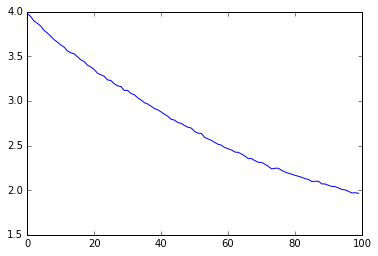

In [132]:
all_kl = []
for epoch in range(100):
    #filename = join(rundir, 'archive/motif_spikein_ATAGGC_SGD_v1_5e-03',\
    #               'plot_epoch_{0:03d}_generated.pkl'.format(epoch))
    filename = join(rundir, 'motif_spikein_ATAGGC/SGD_None_v0_lr5e-03_wgan_ginter5',\
                   'samples_epoch_{0:03d}_generated.pkl'.format(epoch))
    #filename = join(rundir, 'motif_spikein_ATAGGC/OMDA_None_v3_lr5e-04_gan_ginter1',\
    #               'samples_epoch_{0:03d}_generated.pkl'.format(epoch))
    #filename = join(rundir, '../script/test',\
    #               'samples_epoch_{0:03d}_generated.pkl'.format(epoch))
    with open(filename) as f:
        current_sample = cPickle.load(f)
    all_kl.append(kl_compare(current_sample, motif_file, motif_len))

plt.plot(range(100), all_kl)

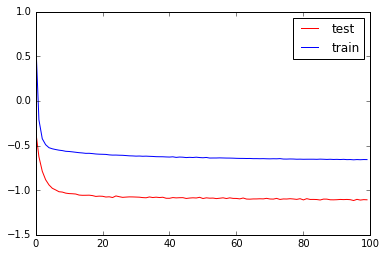

In [113]:
filename = join(rundir, 'motif_spikein_ATAGGC/SGD_None_v0_lr5e-04_wgan_ginter5',\
                   'history.pkl')
    
with open(filename) as f:
    history = cPickle.load(f)

n_points = len(history['test']['discriminator'])
plt.plot(range(n_points), [x[0] for x in history['test']['discriminator']], c='r', label='test')
plt.plot(range(n_points), [x[0] for x in history['train']['discriminator']], c='b', label='train')
plt.legend()

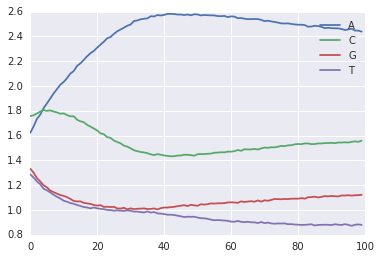

In [165]:
plot_acgt_distr(join(rundir, 'motif_spikein_ATAGGC/OMDA_None_v1_lr5e-04_wgan_ginter5'), 100, 6)

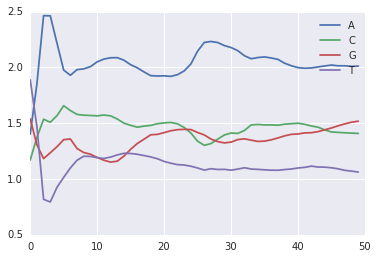

In [167]:
plot_acgt_distr(join(rundir, 'motif_spikein_ATAGGC/OMDA_None_v1_lr5e-04_gan_ginter1'), 50, 6)

### GAN

In [181]:
versions = ['1', '2', '3']
schedules = ['None', 'adagrad']
optimizers = ['OMDA', 'SGD']
network = 'gan'
ginter = 1
lrs = ['5e-03', '5e-04','5e-05']
n_epoch = 49

In [192]:
pattern = join(rundir, dataset, 'OPTIMIZER_SCHEDULE_vVERSION_lrLR_NETWORK_ginterGINTER')
analysis(pattern)

schedule               None   adagrad
optimizer version                    
OMDA      1        3.509687  1.335245
          2        2.225475  1.345353
          3        1.065833  1.205976
SGD       0        1.617046  3.339210

lr                    5e-03               5e-04               5e-05          
schedule               None   adagrad      None   adagrad      None   adagrad
optimizer version                                                            
OMDA      1        1.036016  1.373556  1.088935  1.035387  0.984684  1.342907
          2        1.136099  1.404618  1.171240  1.198822  1.377305  1.155232
          3        1.309471  1.190379  1.306753  1.142249  1.110499  1.016690
SGD       0        1.617046  1.624462  2.588866  3.339210  3.808030  4.231331

## Gaussian

OMDA_None_v1_lr5e-03_gan_ginter1_gp1e-4


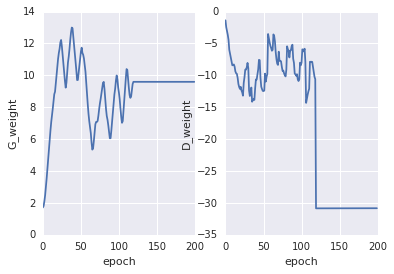

OMDA_None_v1_lr5e-04_gan_ginter1_gp1e-4


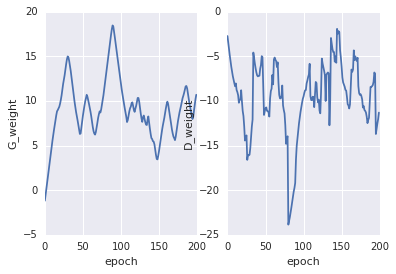

OMDA_None_v1_lr5e-05_gan_ginter1_gp1e-4


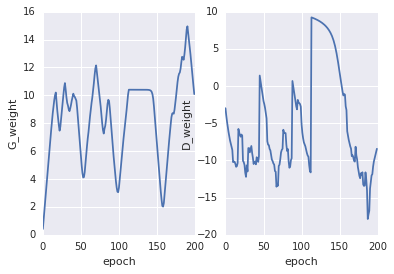

OMDA_None_v1_lr5e-06_gan_ginter1_gp1e-4


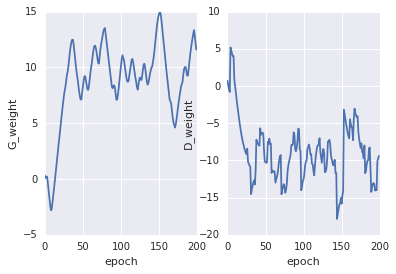

OMDA_None_v1_lr5e-07_gan_ginter1_gp1e-4


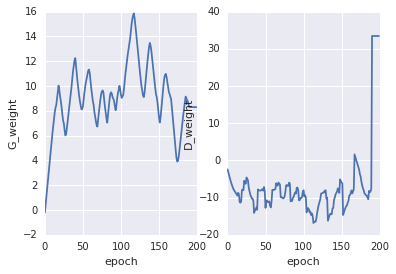

OMDA_adagrad_v1_lr5e-03_gan_ginter1_gp1e-4


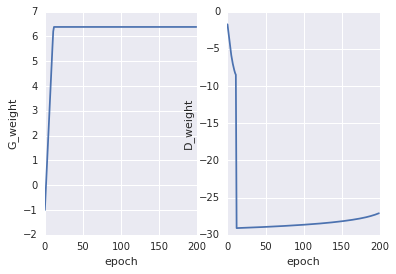

OMDA_adagrad_v1_lr5e-04_gan_ginter1_gp1e-4


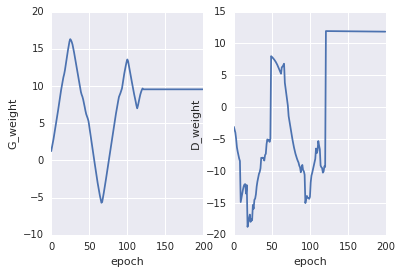

OMDA_adagrad_v1_lr5e-05_gan_ginter1_gp1e-4


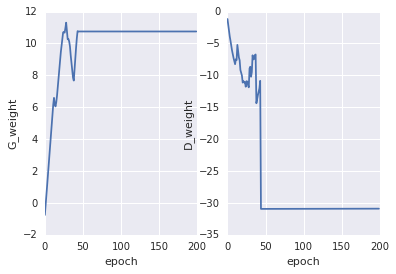

OMDA_adagrad_v1_lr5e-06_gan_ginter1_gp1e-4


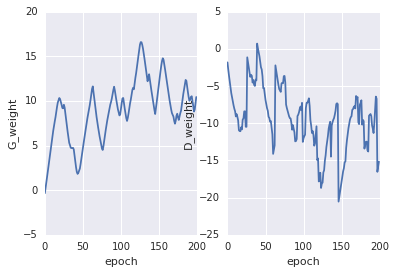

OMDA_adagrad_v1_lr5e-07_gan_ginter1_gp1e-4


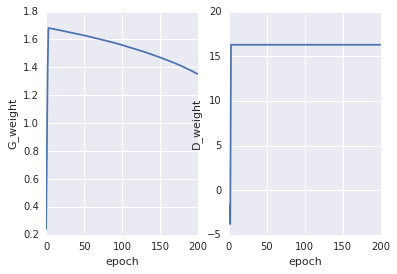

SGD_None_v0_lr5e-03_gan_ginter1_gp1e-4


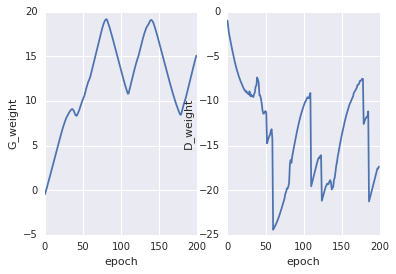

SGD_None_v0_lr5e-04_gan_ginter1_gp1e-4


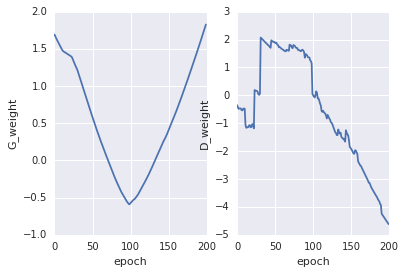

SGD_None_v0_lr5e-05_gan_ginter1_gp1e-4


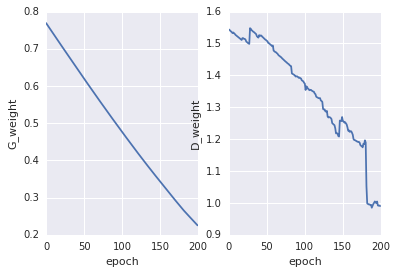

SGD_None_v0_lr5e-06_gan_ginter1_gp1e-4


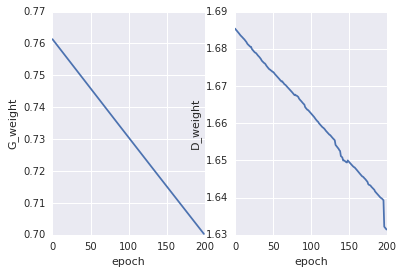

SGD_None_v0_lr5e-07_gan_ginter1_gp1e-4


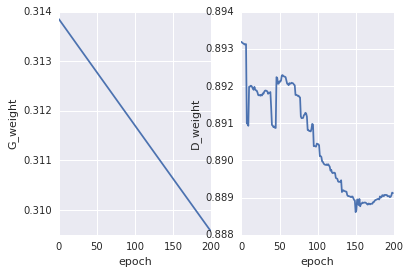

SGD_adagrad_v0_lr5e-03_gan_ginter1_gp1e-4


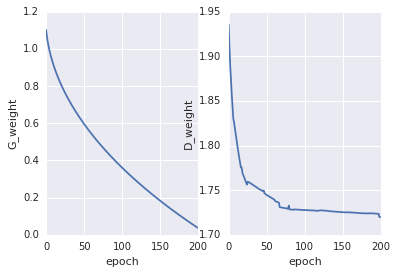

SGD_adagrad_v0_lr5e-04_gan_ginter1_gp1e-4


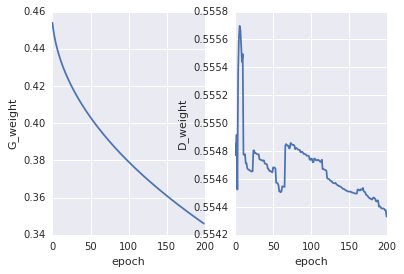

SGD_adagrad_v0_lr5e-05_gan_ginter1_gp1e-4


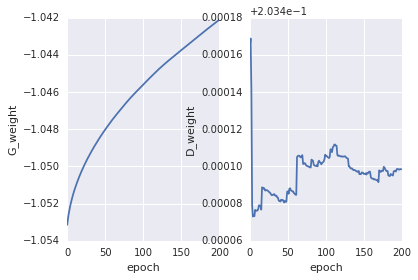

SGD_adagrad_v0_lr5e-06_gan_ginter1_gp1e-4


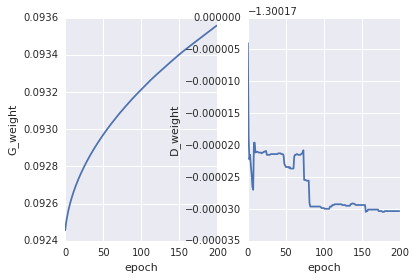

SGD_adagrad_v0_lr5e-07_gan_ginter1_gp1e-4


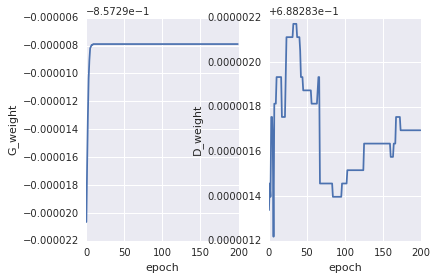

In [171]:
lrs = ['5e-03', '5e-04', '5e-05', '5e-06', '5e-07']
versions = ['1']
schedules = ['None', 'adagrad']
optimizers = ['OMDA', 'SGD']

for optimizer in optimizers:
    for schedule in schedules:
        for lr in lrs:
            version = '1' if optimizer =='OMDA' else '0'
            t_expt = '_'.join([optimizer, schedule, 'v'+version, 'lr'+lr,'gan', 'ginter1', 'gp1e-4'])
            print t_expt
            
            means = []
            G_b = []
            D_b = []
            n_epoch = 200

            for epoch in range(n_epoch):
#                 with open(join(rundir, 'gaussian_m5_v1', t_expt, 'samples_epoch_{0:03d}_generated.pkl'.format(epoch))) as f:
#                     best_sample = cPickle.load(f)
#                     means.append(np.mean(best_sample))
                
                with h5py.File(join(rundir,
                                    'gaussian_m5_v1', t_expt,
                                    'params_generator_epoch_{0:03d}.hdf5'.format(epoch))) as f:
                    G_b.append(np.asarray(f['model_weights']['G']['G']['bias']))
                
                with h5py.File(join(rundir,
                                    'gaussian_m5_v1', t_expt,
                                    'params_discriminator_epoch_{0:03d}.hdf5'.format(epoch))) as f:
                    D_b.append(np.asarray(f['model_weights']['D']['D']['bias']))          
                
            plt.subplot(1, 2, 1)
            plt.plot(range(n_epoch), G_b)
            plt.xlabel('epoch')
            plt.ylabel('G_weight')
            plt.subplot(1, 2, 2)
            plt.plot(range(n_epoch), D_b)
            plt.xlabel('epoch')
            plt.ylabel('D_weight')
            plt.show()

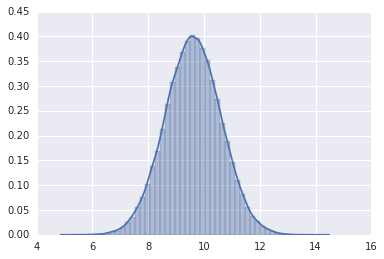

In [145]:
sns.distplot(best_sample)